<a href="https://colab.research.google.com/github/lauratsang/MapChallenge/blob/main/pointsandlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **A map of Starbucks locations in Ocean County, New Jersey**
<br>Following the tutorial by ritvikmath:
https://github.com/ritvikmath/YouTubeVideoCode/blob/cb7056cbf7de8d96d14344e5c4f252f9bc2e370f/Starbucks%20Dists.ipynb

Map adapted by Laura Tsang

Day 1 and 2 of the November #30daymapchallenge (am I allowed to combine the two?). I am trying to build my GIS skills in Python and thought it would be interesting to learn how to scrape web location data and render with folium. Alternatives to make this map more presentable would be to export the Starbucks location files and create a map in ArcGIS or QGIS.


In [36]:
import requests
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from osgeo import gdal
import re
import folium
import json
import fiona
from folium import plugins
import geopy.distance
import seaborn as sns
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [37]:
url = 'https://www.starbucks.com/store-locator?map=40.086335,-74.305655,8z&place=Brick%20Township,%20NJ,%20USA'
response = requests.get(url)

In [67]:
#response.status_code

In [66]:
#response.text

In [68]:
re.findall(r'"coordinates":\{"latitude":(.*?)\,"longitude":(.*?)\}', response.text)

[('40.05847', '-74.14968'),
 ('40.05542', '-74.16432'),
 ('40.0256', '-74.1434'),
 ('40.04574', '-74.22438'),
 ('39.98792', '-74.17413'),
 ('39.98648', '-74.17903'),
 ('39.98029', '-74.1779'),
 ('40.12664', '-74.22177'),
 ('40.13124', '-74.22138'),
 ('40.13875', '-74.06123'),
 ('39.95495', '-74.16127'),
 ('40.15738', '-74.05388'),
 ('40.16541', '-74.05116'),
 ('40.1983', '-74.09911'),
 ('40.22454', '-74.09429'),
 ('40.21024', '-74.25772'),
 ('40.22852', '-74.04513'),
 ('40.23139', '-74.04494'),
 ('39.85971', '-74.20539'),
 ('40.26471', '-74.04241'),
 ('40.24051', '-74.30535'),
 ('40.2534', '-74.30019'),
 ('40.28974', '-74.04725'),
 ('40.29187', '-74.05331'),
 ('40.15563', '-74.42833'),
 ('40.29128', '-74.30186'),
 ('40.30053', '-73.97893'),
 ('40.33207', '-74.11904'),
 ('40.30854', '-74.30362'),
 ('40.33312', '-74.06129'),
 ('40.35075', '-74.06557'),
 ('39.75949', '-74.24626'),
 ('40.35106', '-74.30692'),
 ('40.3541', '-74.3078'),
 ('40.39856', '-74.11102'),
 ('40.31606', '-74.43965'),

In [41]:
def get_store_lat_lngs(zcode):
  request = f'https://www.starbucks.com/store-locator?place={zcode}'
  response = requests.get(request)
  lat_lngs = re.findall(r'"coordinates":\{"latitude":(.*?)\,"longitude":(.*?)\}', response.text)
  lat_lngs = [(float(item[0]), float(item[1])) for item in lat_lngs]
  return lat_lngs

## **Get all Starbucks locations using above function**



In [42]:
oc_zips = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/zipcodes_oceanco.csv')

In [43]:
oc_zips['Zipcode'] = oc_zips['Zipcode'].astype(str)
oc_zips['Zipcode'] = oc_zips['Zipcode'].str.zfill(5)

In [44]:
starbucks_locs = []

In [69]:
for i,zcode in enumerate(oc_zips.Zipcode.values):
  print(f'{i} / {len(oc_zips)}')
  starbucks_locs += get_store_lat_lngs(zcode)

0 / 49
1 / 49
2 / 49
3 / 49
4 / 49
5 / 49
6 / 49
7 / 49
8 / 49
9 / 49
10 / 49
11 / 49
12 / 49
13 / 49
14 / 49
15 / 49
16 / 49
17 / 49
18 / 49
19 / 49
20 / 49
21 / 49
22 / 49
23 / 49
24 / 49
25 / 49
26 / 49
27 / 49
28 / 49
29 / 49
30 / 49
31 / 49
32 / 49
33 / 49
34 / 49
35 / 49
36 / 49
37 / 49
38 / 49
39 / 49
40 / 49
41 / 49
42 / 49
43 / 49
44 / 49
45 / 49
46 / 49
47 / 49
48 / 49


In [46]:
starbucks_locs = set(starbucks_locs)

In [47]:
starbucks_locs = list(starbucks_locs)

In [70]:
# len(starbucks_locs)

In [71]:
# starbucks_locs

## **Distance to the Closest Starbucks**

In [50]:
lat, lon = zip(*starbucks_locs)

In [51]:
dist_matrix = np.empty((len(starbucks_locs), len(starbucks_locs)))
for i1,s1 in enumerate(starbucks_locs):
  for i2,s2 in enumerate(starbucks_locs):
    if i1 <= i2:
      d = geopy.distance.geodesic(s1, s2).mi
      dist_matrix[i1,i2] = d
      dist_matrix[i2,i1] = d

In [52]:
np.fill_diagonal(dist_matrix, np.inf)

In [53]:
closest_locs = np.argmin(dist_matrix, axis=0)
closest_dists = dist_matrix[np.arange(len(starbucks_locs)), closest_locs]

In [57]:
#map of Ocean county
with open('/content/drive/MyDrive/Colab Notebooks/oc_map.geojson') as f:
    ocArea = json.load(f)

oc_lng_lats = ocArea['features'][0]['geometry']['coordinates'][0][0]
polygon = Polygon(oc_lng_lats)

In [62]:
#initialize the map around Ocean County
ocMap = folium.Map(location=[39.902047, -74.281488], zoom_start=9)

#add the shape of Ocean County to the map
folium.GeoJson(ocArea).add_to(ocMap)

#for each row in the Starbucks dataset, plot the corresponding latitude and longitude on the map
for lat,lng in starbucks_locs:
    if polygon.contains(Point(lng,lat)):
        folium.CircleMarker((lat, lng), radius=4, weight=2, color='red', fill_color='red', fill_opacity=.5).add_to(ocMap)

closest_dists_lim = []
closest_locs = np.argmin(dist_matrix, axis=0)
for i1,s1 in enumerate(starbucks_locs):
    if polygon.contains(Point(s1[1],s1[0])):
        s2 = starbucks_locs[closest_locs[i1]]
        d = round(closest_dists[i1], 2)
        folium.PolyLine([s1,s2], color='black', popup=f'{d} miles', fontsize=20).add_to(ocMap)
        closest_dists_lim.append(d)
closest_dists_lim = np.array(closest_dists_lim)

In [65]:
ocMap

In [63]:
#save the map as an html
ocMap.save('/content/drive/MyDrive/Colab Notebooks/ocSbuxMap.html')

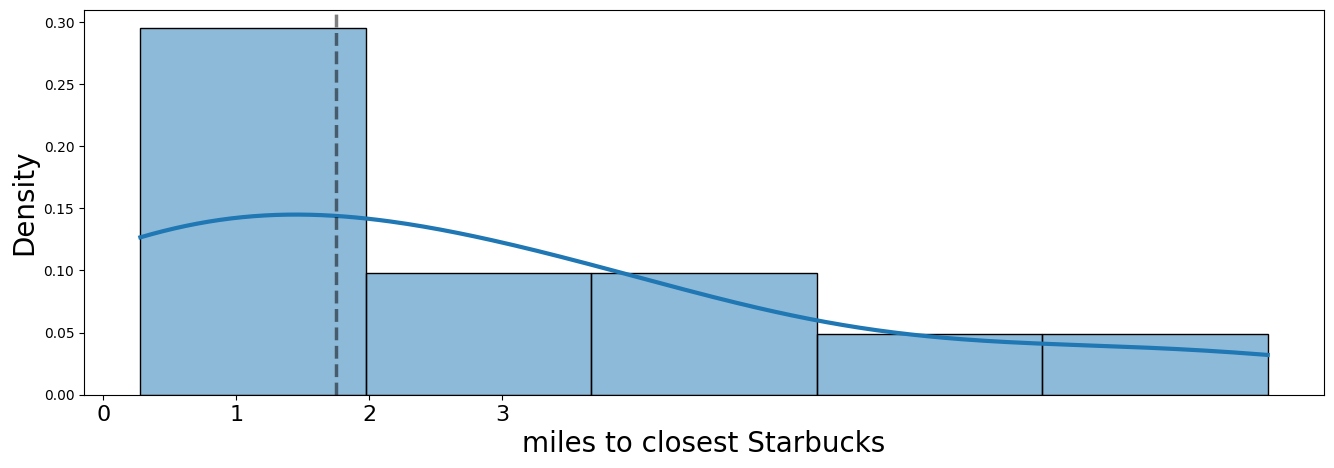

In [64]:
plt.figure(figsize=(16,5))
sns.histplot(closest_dists_lim, kde=True, line_kws={'linewidth': 3}, stat='density')
plt.xlabel('miles to closest Starbucks', fontsize=20)
plt.xticks(np.arange(0, 3.1), fontsize=16)
plt.ylabel('Density', fontsize=20)
plt.axvline(np.mean(closest_dists), color='k', linestyle='--', linewidth=2.5, alpha=0.5)